In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [42]:
datafile = "recorded_sensor_data/field_data_2/auto/mocap_data-175.173.csv"
reader = csv.reader(open(datafile, 'r'))

next(reader) # skip header
raw_data = []
for row in reader:
    raw_data.append(list(map(float, [row[0],row[1],row[2],row[5],row[7],row[8],row[9],row[14]])))
raw_data = np.array(raw_data)

raw_acc_data = np.array(raw_data[:,:3])
yaws = np.array(raw_data[:,3])
temperatures = np.array(raw_data[:,-1])
naxv_displacements = np.array(raw_data[:,4:7])

In [43]:
def get_static_intervals(threshold, data, window_size):
    if window_size % 2 == 0:
        window_size -= 1
    data_array_size = len(data)
    classifications = np.zeros(data_array_size)
    static_indicators = []
    temp_pair = [-1, -1]
    previously_static = False
    for i in range(data_array_size - window_size):
        window_data = data[i:i+window_size]
        center = i + window_size // 2
        variance = np.sum(np.var(window_data[:, :3], axis = 0)**2)
        
        #end of a static interval
        static = variance < threshold
        if not static and previously_static:
            temp_pair[1] = center
            static_indicators.append(temp_pair)
            temp_pair = [-1, -1]
        #start of a static intervals
        elif static and not previously_static:
            temp_pair[0] = center
        
        previously_static = static
        classifications[center] = 1.5 if static else -1
        
    if previously_static:
        print("static at the end")
        temp_pair[1] = data_array_size - window_size // 2 - 1
        static_indicators.append(temp_pair)
    
    return static_indicators, classifications   

[[39, 237], [732, 1092], [1940, 2308], [3533, 3901]]


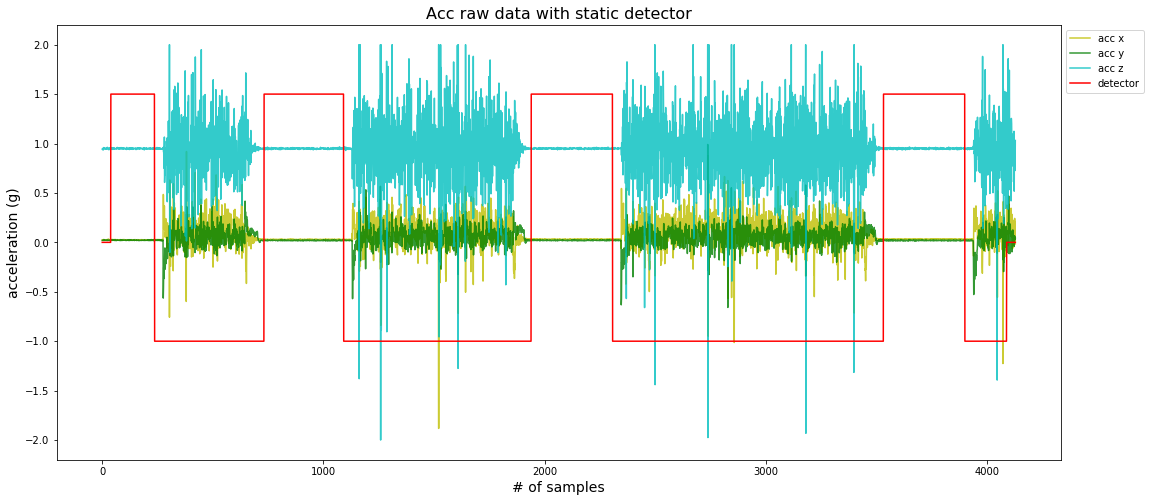

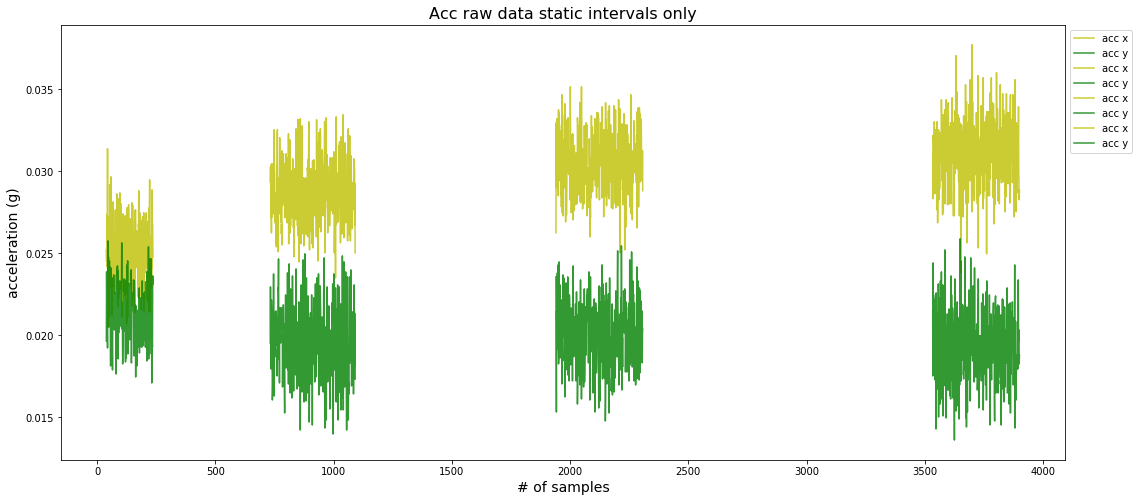

In [44]:
# static_guess = [[0, 95],[600,950],[1800,2200],[3350,3800], [5300,5700]]

init_variance = np.linalg.norm(np.var(raw_acc_data[:, :80], axis=0))

static_guess, classification = get_static_intervals(init_variance**6, raw_acc_data, 80)

print(static_guess)
opacity = 0.8

plt.figure(figsize=(18,8))
plt.title("Acc raw data with static detector", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
plt.plot(raw_data[:,0] , c = 'y', alpha = opacity, label = 'acc x')
plt.plot(raw_data[:,1] , c = 'g', alpha = opacity, label = 'acc y')
plt.plot(raw_data[:,2] , c = 'c', alpha = opacity, label = 'acc z')
# for g in static_guess:
#     plt.plot([g[0],g[0]],[-1.5,2.0], c = 'r')
#     plt.plot([g[1],g[1]],[-1.5,2.0], c = 'r')
plt.plot(classification, c = 'r', label = 'detector')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


plt.figure(figsize=(18,8))
plt.title("Acc raw data static intervals only", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
for g in static_guess:
    plt.plot(range(g[0], g[1]),raw_data[g[0]:g[1],0], c = 'y', alpha = opacity, label = 'acc x')
    plt.plot(range(g[0], g[1]),raw_data[g[0]:g[1],1], c = 'g', alpha = opacity, label = 'acc y')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

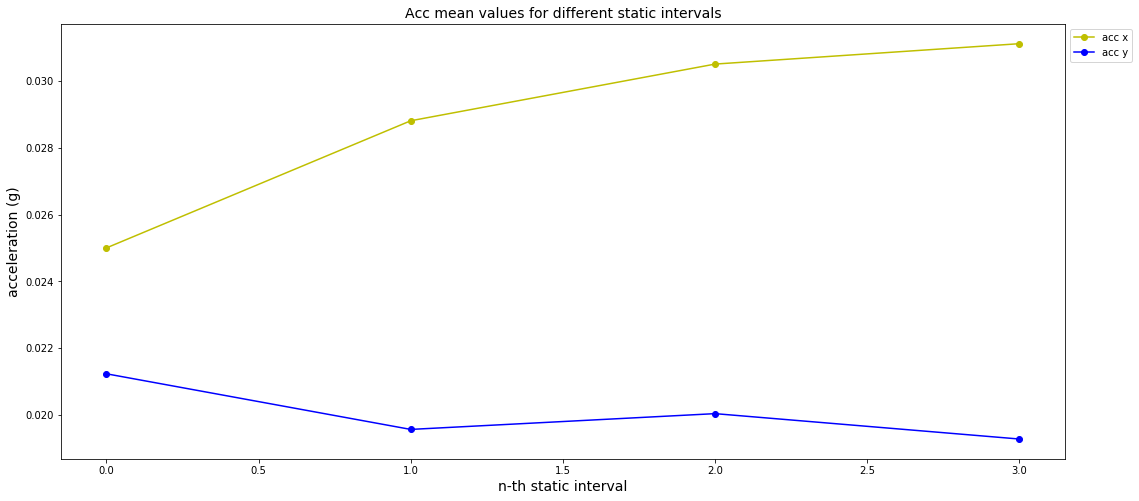

In [45]:
def find_static_mean(data, static_intervals):
    averages = []

    for x in static_intervals:
        averages.append(np.mean(data[x[0]: x[1],:], axis = 0))

    averages = np.array(averages)    
    
    return averages

def plot_static_mean(data, static_intervals):
    averages = find_static_mean(data,static_intervals)
    
    plt.figure(figsize=(18,8))
    plt.title("Acc mean values for different static intervals", fontsize = 14)
    plt.ylabel("acceleration (g)", fontsize = 14)
    plt.xlabel("n-th static interval", fontsize = 14)
    plt.plot(averages[:,0], c = 'y',marker = 'o', label = "acc x")
    plt.plot(averages[:,1], c = 'b', marker = 'o', label = "acc y")
#     plt.plot(averages[:,2], c = 'c', marker = 'o', label = "acc z")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

plot_static_mean(raw_data,static_guess)

In [46]:
def clockwise_yaw_rotation_matrix(yaw_angle):
    # https://en.wikipedia.org/wiki/Rotation_matrix
    R = np.array([[np.cos(yaw_angle), np.sin(yaw_angle), 0],
                        [-np.sin(yaw_angle), np.cos(yaw_angle), 0],
                        [0, 0, 1]])
    return R

def integrate_sth(data, dt, convertion_factor):
    result = np.zeros(data.shape)
    v_i = 0
    for i in range(1, len(data)):
        a = data[i] / 2 + data[i - 1] / 2
        v_f = a * dt * convertion_factor + v_i
        result[i] = v_f
        v_i = v_f
    return result


def integrate_velocity_with_yaw(data, dt, convertion_factor, yaws):
    result = np.zeros(data.shape)
    v_i = 0
    for i in range(1, len(data)):
        a = data[i] / 2 + data[i - 1] / 2
        
        a = (clockwise_yaw_rotation_matrix(yaws[i] / 180 * np.pi) @ a.T).T
        v_f = a * dt * convertion_factor + v_i
        result[i] = v_f
        v_i = v_f
    return result

def calibrate(input_data):
    # Ideal accelerometer calibration parameters
    acc_calibration_params = np.array([2.29299485e-03, 9.73357832e-04, 2.18891523e-03,
                                   9.97372417e-01, 9.98078141e-01, 9.95206414e-01,
                                   -8.12765191e-03, -1.24052008e-02, -1.41327621e-02])
    # Ideal gyro calibration parameters
    gyro_calibration_params = np.array([0.00844165, 0.00196508, -0.00410652,
                                       -0.01548789, -0.00191488, -0.00770839,
                                       0.40658698, 0.40275294, 0.40165824])
    
    Ta = np.array([[1, -acc_calibration_params[0], acc_calibration_params[1]],
                   [0, 1, -acc_calibration_params[2]],
                   [0, 0, 1]])
    
    Tg = np.array([[1, -gyro_calibration_params[0], gyro_calibration_params[1]],
                   [gyro_calibration_params[2], 1, -gyro_calibration_params[3]],
                   [-gyro_calibration_params[4], gyro_calibration_params[5], 1]])
    
    Ka = np.array([[acc_calibration_params[3], 0, 0],
                   [0, acc_calibration_params[4], 0],
                   [0, 0, acc_calibration_params[5]]])
    
    Kg = np.array([[gyro_calibration_params[6], 0, 0],
                   [0, gyro_calibration_params[7], 0],
                   [0, 0, gyro_calibration_params[8]]])

    ba = acc_calibration_params[6:9]
#     ba = acc_bias
    bg = np.array([0.12964524, 0.15079131, 0.08211978])
    
    output_data = np.empty((input_data.shape[0], 6))
    output_data[:,0:3] = (Ta@Ka@(input_data[:,0:3] + ba).T).T
#     output_data[:,3:6] = (Tg@Kg@(input_data[:,3:6] + bg).T).T
    
    return output_data

def base_rotation(mean_acc_while_stationary):
    """ https://math.stackexchange.com/questions/180418/
    calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d """
    a = mean_acc_while_stationary
    b = np.array([0, 0, 1])
    v = np.cross(a, b)
    c = np.dot(a, b)
    v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = np.eye(3) + v_x + (v_x@v_x)*(1/(1+c))
    return R


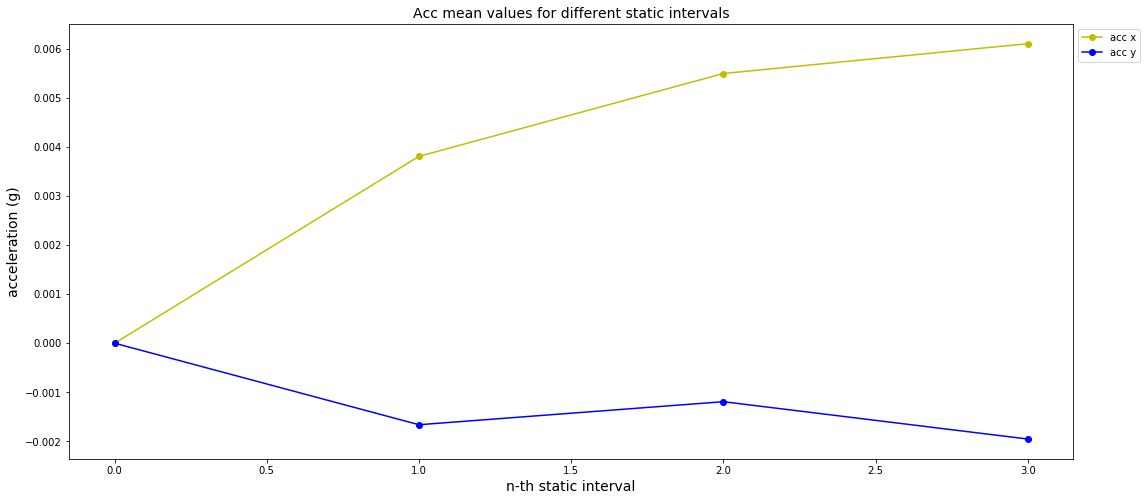

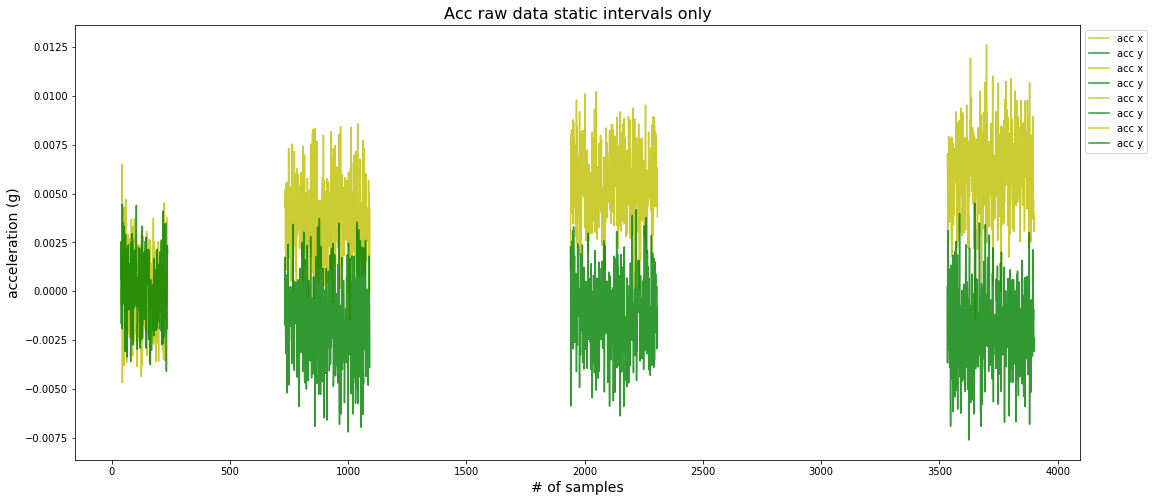

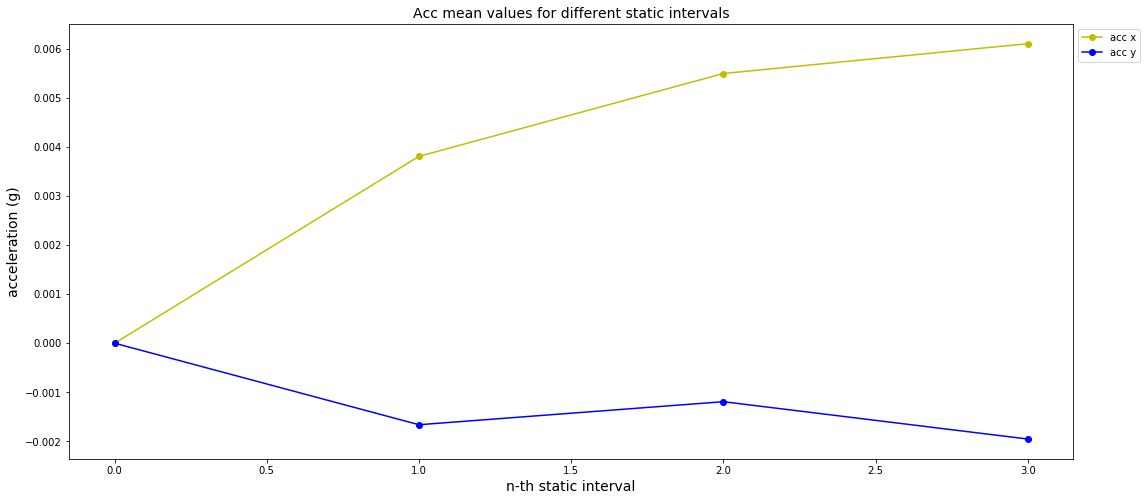

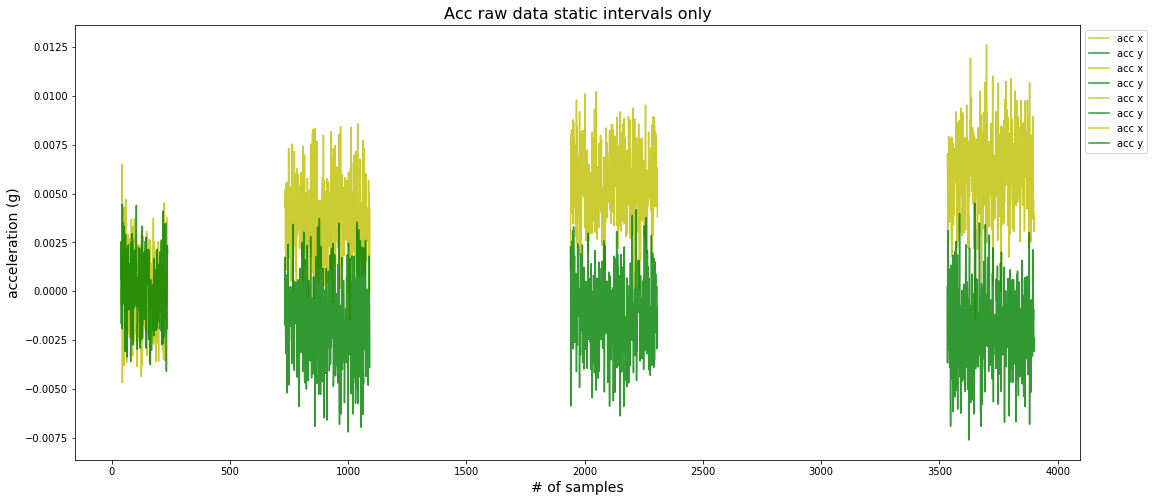

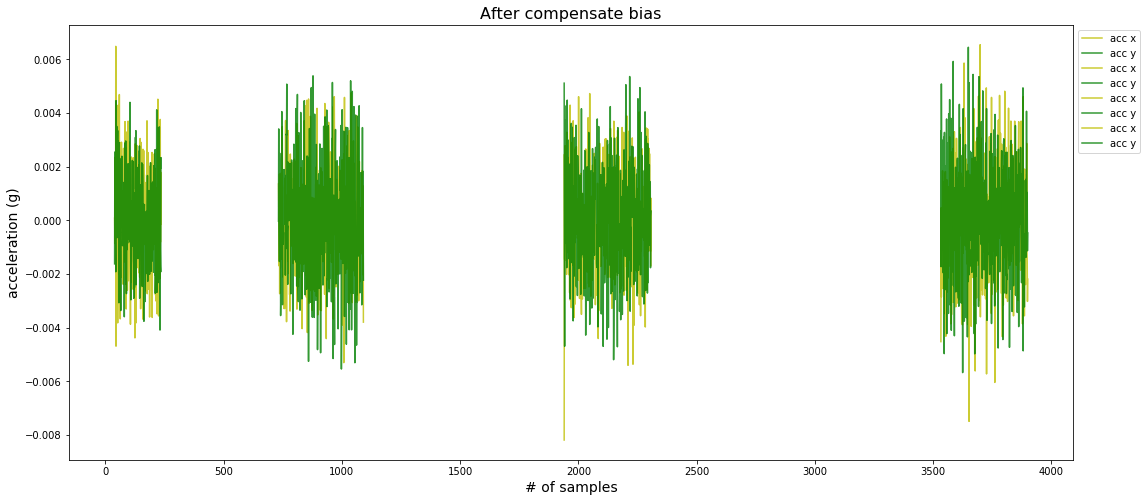

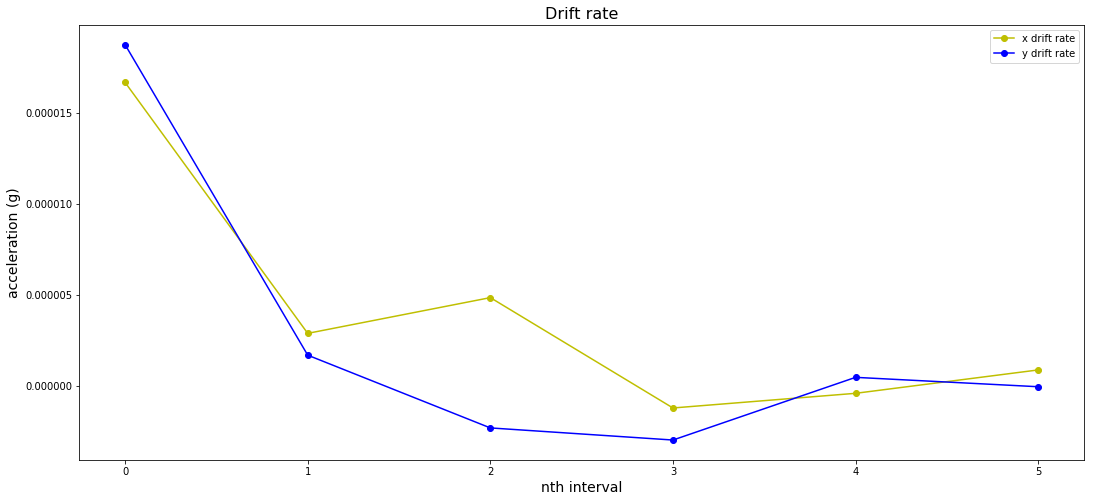

In [47]:
#calibrate first
calibrated_acc_data = calibrate(raw_acc_data)[:,:3]

#allocate space
final_acc_data = np.array(raw_acc_data.shape)

calibrated_mean = np.mean(calibrated_acc_data[static_guess[0][0]:static_guess[0][1],:], axis = 0)

unit_calibrated_mean = calibrated_mean / np.linalg.norm(calibrated_mean)

#find out the rotation matrix
R = base_rotation(unit_calibrated_mean)

halfway_acc_data = (R @ calibrated_acc_data.T).T
# halfway_acc_data = (R @ raw_acc_data.T).T


final_acc_data = np.copy(halfway_acc_data) 
    
#compansate drifting 
average_means = find_static_mean(raw_acc_data, static_guess)

plot_static_mean(final_acc_data,static_guess)

plt.figure(figsize=(18,8))
plt.title("Acc raw data static intervals only", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
for g in static_guess:
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],0], c = 'y', alpha = opacity, label = 'acc x')
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],1], c = 'g', alpha = opacity, label = 'acc y')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


def some_equation(drift_rate, dx):
    return drift_rate * dx

# drift_rates = np.zeros((len(static_guess) - 1, 3))
# for i,d in enumerate(static_guess):   
#     if i != 0:
#         start = static_guess[i - 1][0]
#         end = static_guess[i - 1][1]
#         start_mean = np.mean(final_acc_data[start : start + 20], axis = 0)
#         end_mean = np.mean(final_acc_data[end - 20 : end], axis = 0)
        
#         drift_rate = (end_mean - start_mean) / (end - start - 20)
#         drift_rates[i - 1] = drift_rate
#         for j in range(start, static_guess[i][0]):
#             final_acc_data[j] -= some_equation(drift_rate, j - start)


plot_static_mean(final_acc_data,static_guess)  


plt.figure(figsize=(18,8))
plt.title("Acc raw data static intervals only", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
for g in static_guess:
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],0], c = 'y', alpha = opacity, label = 'acc x')
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],1], c = 'g', alpha = opacity, label = 'acc y')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#compansate bias 
for i in range(len(static_guess)):   
    left_bound = static_guess[i][0]
    right_bound = static_guess[i][1]
    static_interval_mean = np.mean(final_acc_data[left_bound : right_bound + 1,:], axis = 0)
    
    bias = [0,0, 1] - static_interval_mean 
    if i != (len(static_guess) - 1):
        right_dyn_bound = static_guess[i + 1][0]
        for j in range(left_bound, right_dyn_bound + 1):
            final_acc_data[j] += bias
    else:
        for j in range(left_bound, len(final_acc_data)):
            final_acc_data[j] += bias    

plt.figure(figsize=(18,8))
plt.title("After compensate bias", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
for g in static_guess:
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],0], c = 'y', alpha = opacity, label = 'acc x')
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],1], c = 'g', alpha = opacity, label = 'acc y')
plt.legend(bbox_to_anchor=(1,1))
plt.show()            
            
plt.figure(figsize=(18,8))
plt.title("Drift rate", fontsize = 16)
plt.xlabel("nth interval", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
plt.plot(drift_rates[:,0], c = 'y', label = 'x drift rate', marker='o')
plt.plot(drift_rates[:,1], c = 'b', label = 'y drift rate', marker='o')

plt.legend(bbox_to_anchor=(1,1))
plt.show()

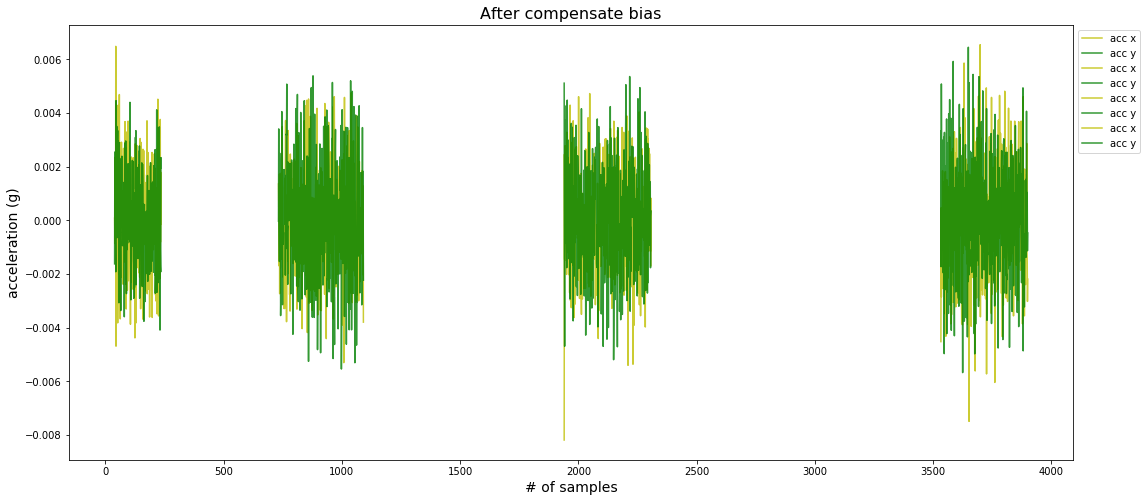

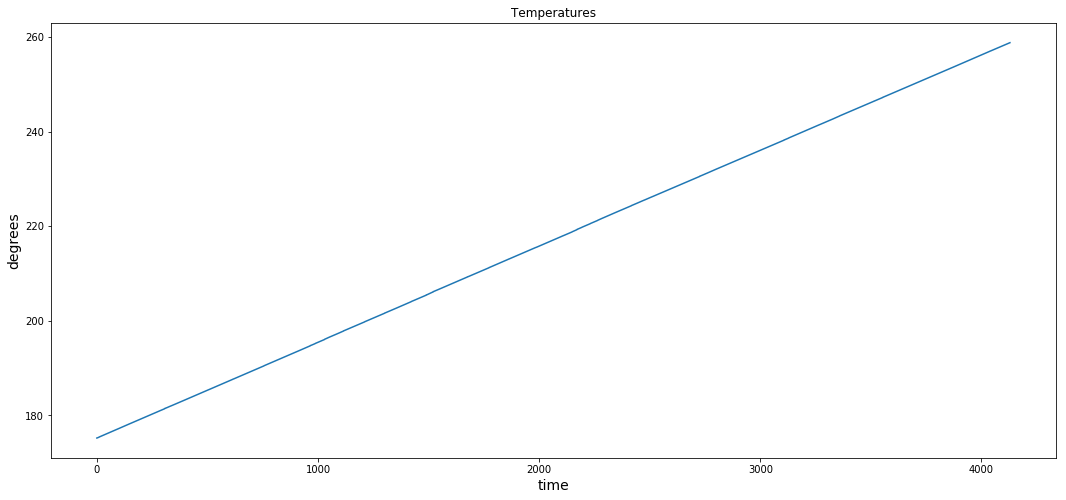

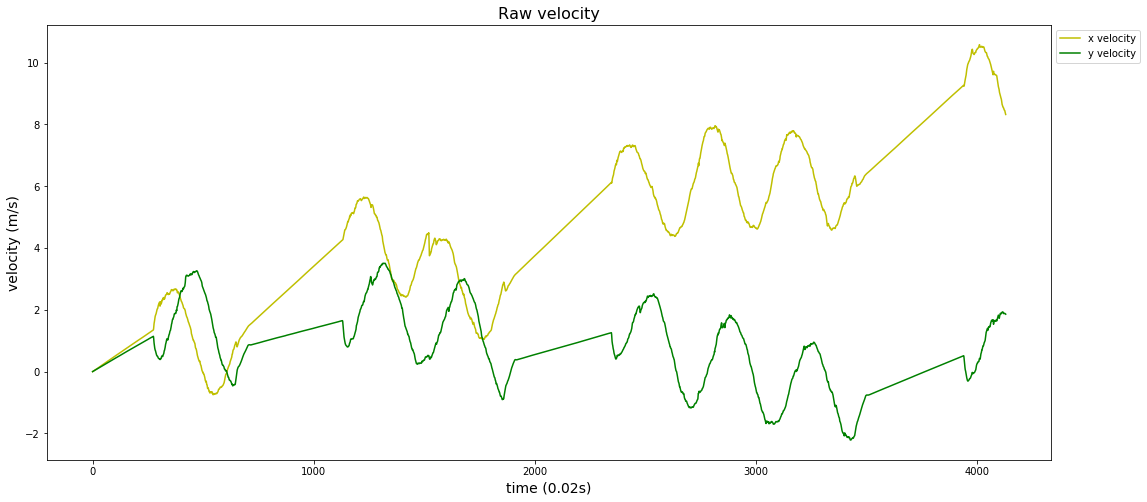

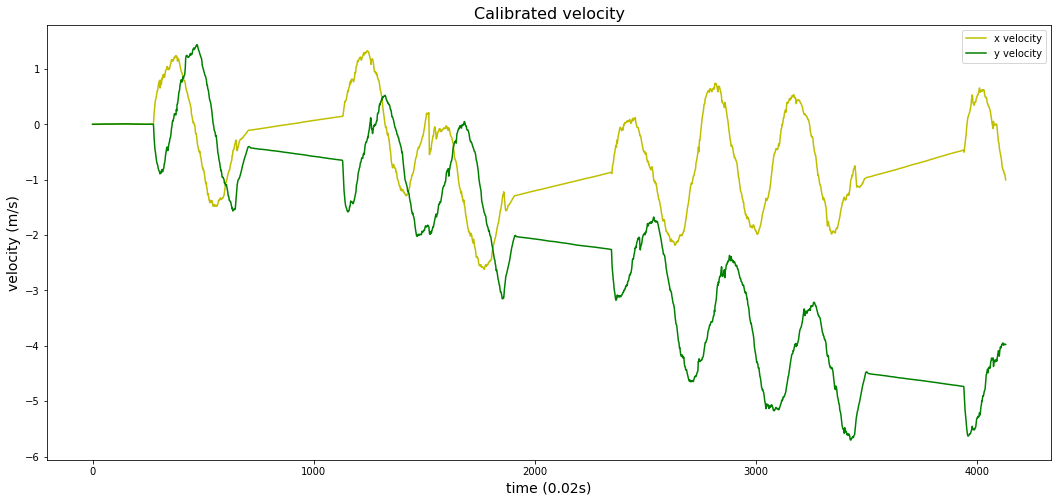

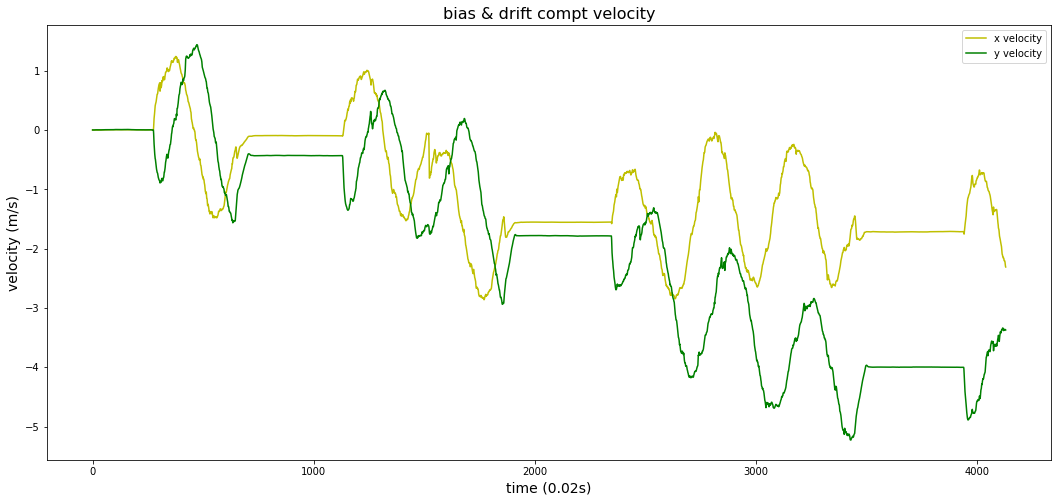

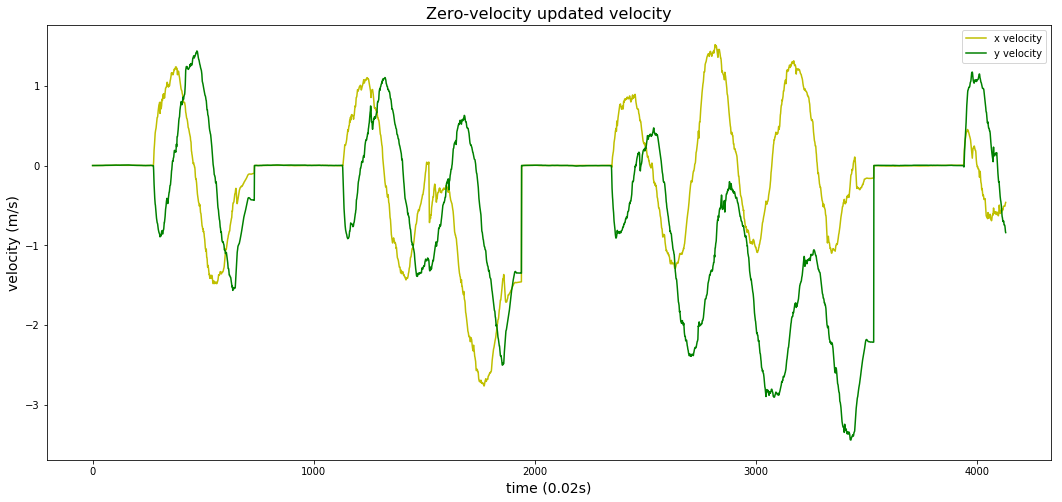

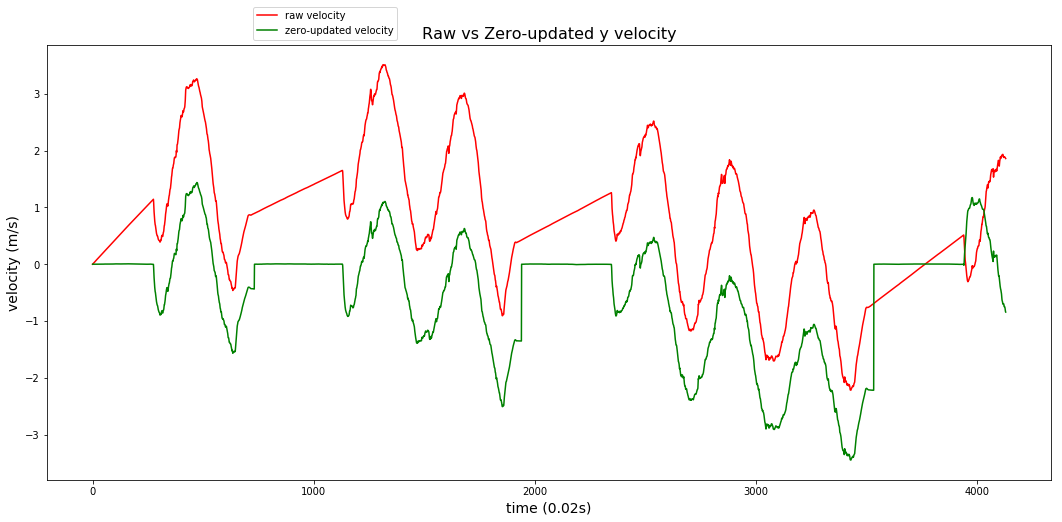

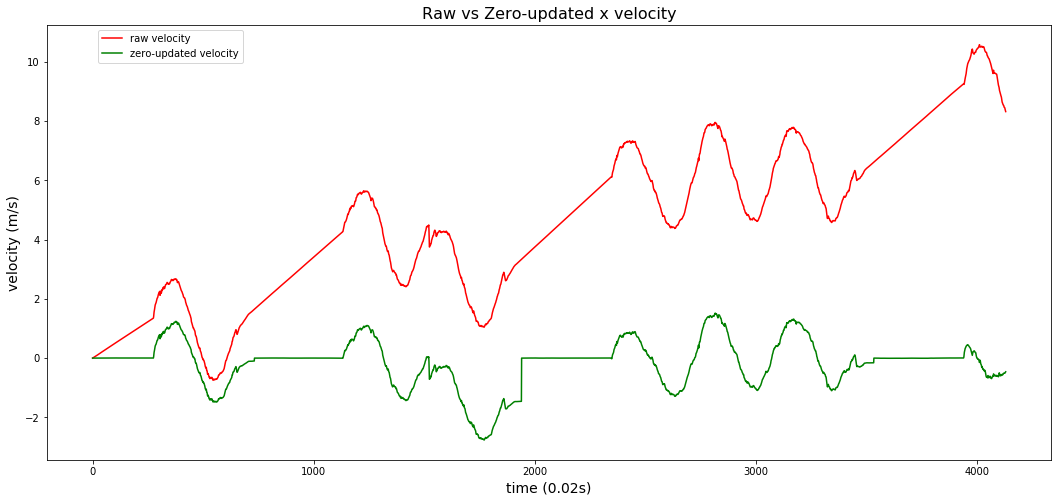

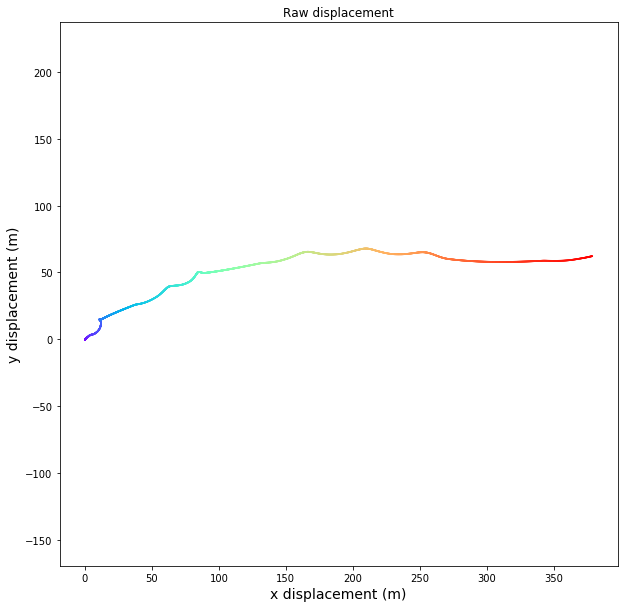

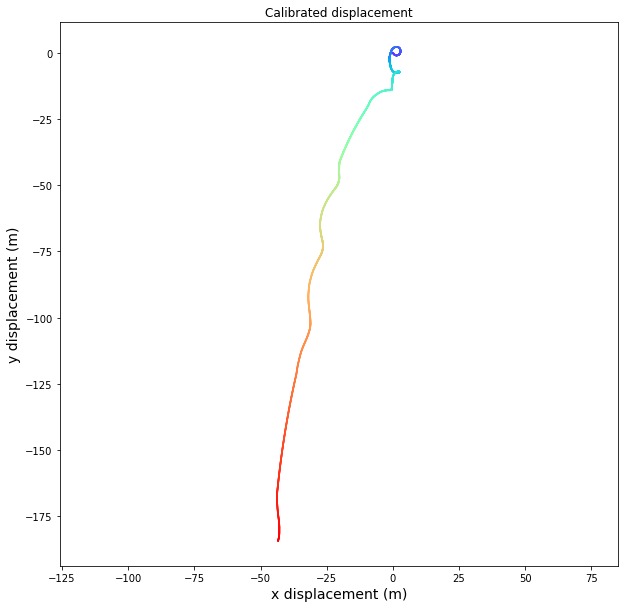

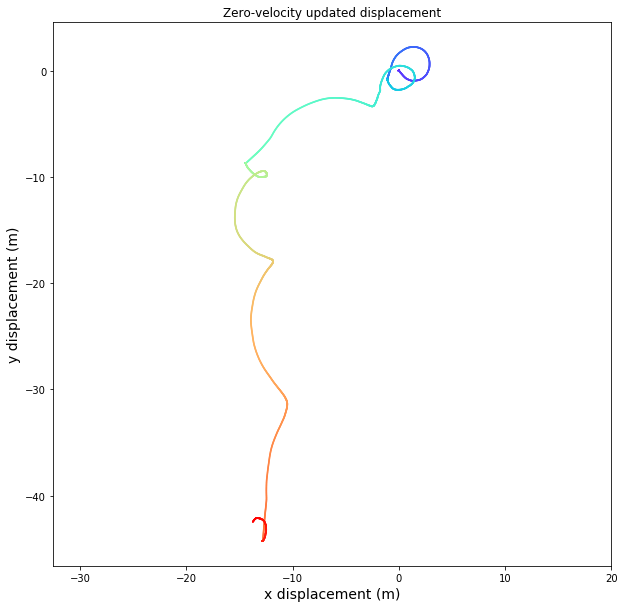

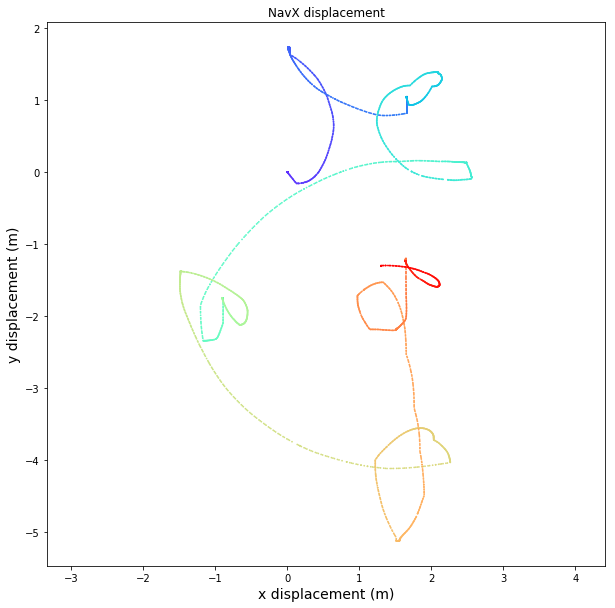

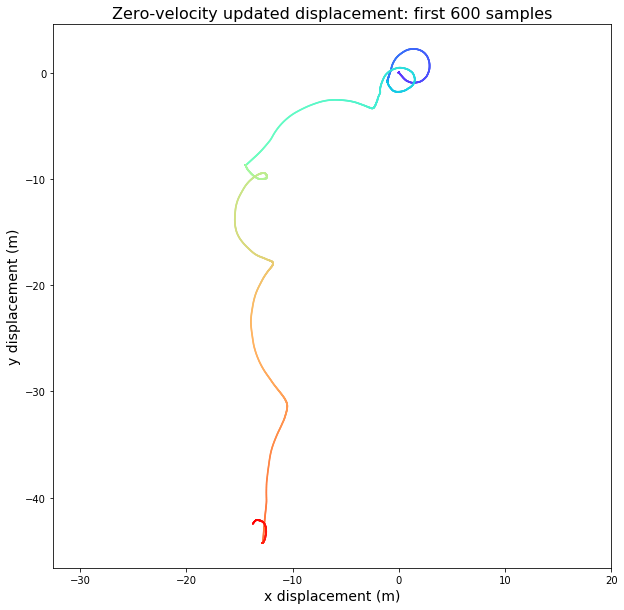

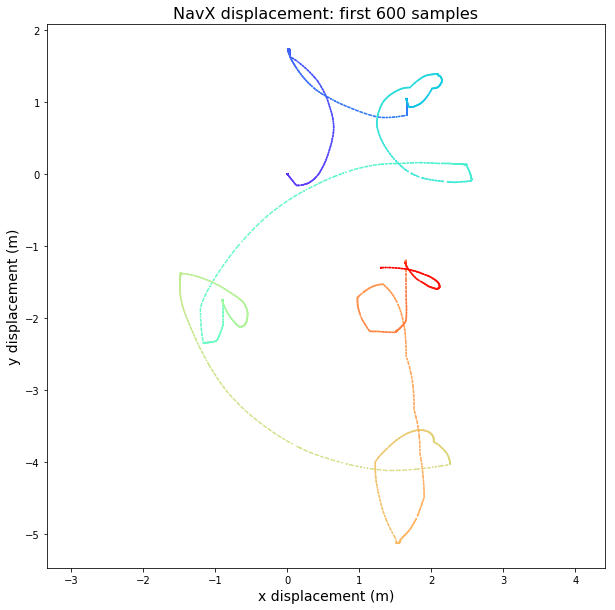

In [48]:
raw_velocity = integrate_velocity_with_yaw(raw_acc_data, 0.02, 9.8, yaws)

raw_displacement = integrate_sth(raw_velocity, 0.02, 1)

halfway_velocity = integrate_velocity_with_yaw(halfway_acc_data, 0.02, 9.8, yaws)

halfway_displacement = integrate_sth(halfway_velocity, 0.02, 1)

final_velocity = integrate_velocity_with_yaw(final_acc_data, 0.02, 9.8,yaws)

final_velocity_zeroed = np.zeros(final_acc_data.shape)
for i in range(len(static_guess)):
    left = static_guess[i][0]
    if i != (len(static_guess) - 1):
        right = static_guess[i + 1][0]
        final_velocity_zeroed[left:right] = integrate_velocity_with_yaw(
            final_acc_data[left:right], 0.02, 9.8, yaws[left:right])
    else:
        final_velocity_zeroed[left:] = integrate_velocity_with_yaw(final_acc_data[left:], 0.02, 9.8, yaws)

plt.figure(figsize=(18,8))
plt.title("After compensate bias", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
for g in static_guess:
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],0], c = 'y', alpha = opacity, label = 'acc x')
    plt.plot( range(g[0], g[1]),final_acc_data[g[0]:g[1],1], c = 'g', alpha = opacity, label = 'acc y')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
        
final_displacement = integrate_sth(final_velocity_zeroed, 0.02, 1)

plt.figure(figsize=(18,8))
plt.title("Temperatures", fontsize = 12)
plt.xlabel("time", fontsize = 14)
plt.ylabel("degrees", fontsize = 14)
plt.plot(temperatures)
plt.show()


plt.figure(figsize=(18,8))
plt.title("Raw velocity", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(raw_velocity[:,0] , c = 'y', label = 'x velocity')
plt.plot(raw_velocity[:,1] , c = 'g', label = 'y velocity')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.figure(figsize=(18,8))
plt.title("Calibrated velocity", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(halfway_velocity[:,0] , c = 'y', label = 'x velocity')
plt.plot(halfway_velocity[:,1] , c = 'g', label = 'y velocity')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


plt.figure(figsize=(18,8))
plt.title("bias & drift compt velocity", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(final_velocity[:,0] , c = 'y', label = 'x velocity')
plt.plot(final_velocity[:,1] , c = 'g', label = 'y velocity')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


plt.figure(figsize=(18,8))
plt.title("Zero-velocity updated velocity", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(final_velocity_zeroed[:,0] , c = 'y', label = 'x velocity')
plt.plot(final_velocity_zeroed[:,1] , c = 'g', label = 'y velocity')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


plt.figure(figsize=(18,8))
plt.title("Raw vs Zero-updated y velocity", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(raw_velocity[:,1] , c = 'r', label = 'raw velocity')
plt.plot(final_velocity_zeroed[:,1] , c = 'g', label = 'zero-updated velocity')
plt.legend(bbox_to_anchor=(0.2,1))
plt.show()

plt.figure(figsize=(18,8))
plt.title("Raw vs Zero-updated x velocity", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(raw_velocity[:,0] , c = 'r', label = 'raw velocity')
plt.plot(final_velocity_zeroed[:,0] , c = 'g', label = 'zero-updated velocity')
plt.legend(bbox_to_anchor=(0.2,1))
plt.show()


colors = cm.rainbow(np.linspace(0, 1, (len(raw_data))))

plt.figure(figsize=(10,10))
plt.title("Raw displacement", fontsize = 12)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.scatter(raw_displacement[:,0], raw_displacement[:,1], s=.5, color=colors)
plt.axis("equal")
plt.show()

plt.figure(figsize=(10,10))
plt.title("Calibrated displacement", fontsize = 12)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.scatter(halfway_displacement[:,0], halfway_displacement[:,1], s=.5, color=colors)
plt.axis("equal")
plt.show()

plt.figure(figsize=(10,10))
plt.title("Zero-velocity updated displacement", fontsize = 12)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.scatter(final_displacement[:,0], final_displacement[:,1], s=.5, color=colors)
plt.axis("equal")
plt.show()


plt.figure(figsize=(10,10))
plt.title("NavX displacement", fontsize = 12)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.scatter(naxv_displacements[:,0], naxv_displacements[:,1], s=.5, color=colors)
plt.axis("equal")
plt.show()


plt.figure(figsize=(10,10))
plt.title("Zero-velocity updated displacement: first 600 samples", fontsize = 16)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.scatter(final_displacement[:6000,0], final_displacement[:6000,1], s=.5, color=colors)
plt.axis("equal")
plt.show()


plt.figure(figsize=(10,10))
plt.title("NavX displacement: first 600 samples", fontsize = 16)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.scatter(naxv_displacements[:6000,0], naxv_displacements[:6000,1], s=.5, color=colors)
plt.axis("equal")
plt.show()
